### <Center> Лабораторна робота №9. <br> Оцінка інформативності ознак за допомогою градієнтного бустінгу

Детальних інструкцій не буде, завдання буде описано тезисно. Рекомендується використати метод Xgboost чи Catboost, та визначити інформативність ознак.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [9]:
train = pd.read_csv('data/flight_delays_train.csv')
test = pd.read_csv('data/flight_delays_test.csv')

In [10]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [11]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Необхідно за часом вильоту літака, коду авіакомпанії-перевізника, місцю вильоту і прильоту і відстанню між аеропортами вильоту і прильоту зпрогнозувати затримку вильоту більше 15 хвилин. 

## Завдання 1. Створити вибірку :
* ознаки Distance і DepTime використати без змін;
* створити ознаку "маршрут" на  основі Origin та Dest;
* до ознак Month, DayofMonth, DayOfWeek, UniqueCarrier і "маршрут" застосувати OHE-перетворення (LabelBinarizer);

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# 2. Створення ознаки "маршрут" на основі 'Origin' та 'Dest'
train['Route'] = train['Origin'] + '_' + train['Dest']
test['Route'] = test['Origin'] + '_' + test['Dest']

# Перевірка створення нової ознаки
print("\nТренувальні дані після створення ознаки 'Route':")
print(train[['Origin', 'Dest', 'Route']].head())

# 3. Застосування One-Hot Encoding (OHE) до категоріальних ознак
# Визначення категоріальних ознак
categorical_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Route']

# Ініціалізація OneHotEncoder
# handle_unknown='ignore' забезпечує, що невідомі категорії в тестових даних не викличуть помилку
# sparse_output=False повертає масив у щільній формі
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Підгонка енкодера на тренувальних даних
encoder.fit(train[categorical_features])

# Трансформація тренувальних та тестових даних
train_encoded = encoder.transform(train[categorical_features])
test_encoded = encoder.transform(test[categorical_features])

# Отримання імен ознак після OHE
encoded_columns = encoder.get_feature_names_out(categorical_features)

# Створення DataFrame з енкодованими ознаками
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_columns, index=train.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_columns, index=test.index)

# Перевірка розмірності після енкодингу
print(f"\nРозмірність тренувальних даних після OHE: {train_encoded_df.shape}")
print(f"Розмірність тестових даних після OHE: {test_encoded_df.shape}")

# Об'єднання енкодованих ознак з числовими ознаками
train_final = pd.concat([train[['Distance', 'DepTime']], train_encoded_df], axis=1)
test_final = pd.concat([test[['Distance', 'DepTime']], test_encoded_df], axis=1)

# Перевірка фінальної вибірки
print("\nФінальна вибірка тренувальних даних:")
print(train_final.head())

# Обробка цільової змінної
# Перетворення 'dep_delayed_15min' з 'Y'/'N' у 1/0
train_final['Delay'] = (train['dep_delayed_15min'] == 'Y').astype(int)

# Перегляд розподілу цільової змінної
print("\nРозподіл цільової змінної 'Delay':")
print(train_final['Delay'].value_counts())

# Очищення пам'яті
del train_encoded, test_encoded, train_encoded_df, test_encoded_df

# Перевірка наявності пропущених значень
print("\nПеревірка пропущених значень у тренувальних даних:")
print(train_final.isnull().sum())
print("\nПеревірка пропущених значень у тестових даних:")
print(test_final.isnull().sum())


Тренувальні дані після створення ознаки 'Route':
  Origin Dest    Route
0    ATL  DFW  ATL_DFW
1    PIT  MCO  PIT_MCO
2    RDU  CLE  RDU_CLE
3    DEN  MEM  DEN_MEM
4    MDW  OMA  MDW_OMA

Розмірність тренувальних даних після OHE: (100000, 4501)
Розмірність тестових даних після OHE: (100000, 4501)

Фінальна вибірка тренувальних даних:
   Distance  DepTime  Month_c-1  Month_c-10  Month_c-11  Month_c-12  \
0       732     1934        0.0         0.0         0.0         0.0   
1       834     1548        0.0         0.0         0.0         0.0   
2       416     1422        0.0         0.0         0.0         0.0   
3       872     1015        0.0         0.0         1.0         0.0   
4       423     1828        0.0         1.0         0.0         0.0   

   Month_c-2  Month_c-3  Month_c-4  Month_c-5  ...  Route_XNA_IAH  \
0        0.0        0.0        0.0        0.0  ...            0.0   
1        0.0        0.0        1.0        0.0  ...            0.0   
2        0.0        0.0      

## Завдання 2. Побудувати модель і оцінити інформативність ознак :
* побудувати модель на основі xgboost;
* налаштувати гіперпараметри з використанням крос-валідації;
* оцінити інформативність ознак.

In [15]:

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint
import time

# Розділення даних на ознаки та цільову змінну
X = train_final.drop(['Delay'], axis=1)
y = train_final['Delay']

# 2. Розділення на тренувальні та валідаційні вибірки
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Стандартизація числових ознак
scaler = StandardScaler()
numeric_features = ['Distance', 'DepTime']

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])

# Побудова базової моделі XGBoost з використанням GPU
# Використання tree_method='hist' і device='cuda' для GPU
model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    tree_method='hist',  # Метод побудови дерев
    device='cuda'  # Використання GPU через CUDA
)

# Тренування моделі на тренувальних даних
print("\nТренування базової моделі XGBoost на GPU...")
model.fit(X_train, y_train)

# Прогнозування на валідаційній вибірці
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Оцінка моделі з використанням ROC AUC
auc = roc_auc_score(y_val, y_pred_proba)
print(f'\nБазовий ROC AUC на валідаційній вибірці: {auc:.4f}')

# Налаштування гіперпараметрів з Randomized Search на GPU
param_dist = {
    'n_estimators': randint(150, 300),
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.3),
    'min_child_weight': randint(1, 10),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 1.5)
}

# Ініціалізація RandomizedSearchCV з GPU
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        tree_method='hist',  # Метод дерев
        device='cuda',  # Використання GPU через CUDA
    ),
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=3
)

# Виконання RandomizedSearchCV
start_time = time.time()
random_search.fit(X_train, y_train)

# Виведення часу виконання
print(f"\nЧас виконання: {time.time() - start_time:.2f} секунд")

# Виведення найкращих параметрів
print(f'\nНайкращі гіперпараметри: {random_search.best_params_}')
print(f'Найкращий ROC AUC: {random_search.best_score_:.4f}')



Тренування базової моделі XGBoost на GPU...

Базовий ROC AUC на валідаційній вибірці: 0.7289
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Час виконання: 898.41 секунд

Найкращі гіперпараметри: {'colsample_bytree': np.float64(0.7894324477537793), 'gamma': np.float64(0.13154223690542607), 'learning_rate': np.float64(0.21160784058855983), 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 212, 'reg_alpha': np.float64(0.9818408883105311), 'reg_lambda': np.float64(1.758400253104045), 'subsample': np.float64(0.9302023091558376)}
Найкращий ROC AUC: 0.7305



Топ-10 найінформативніших ознак:
               feature  importance
1              DepTime    0.013381
59    UniqueCarrier_EV    0.008701
63    UniqueCarrier_HP    0.008472
15     DayofMonth_c-10    0.007060
11           Month_c-7    0.006973
4038     Route_SFO_SMF    0.006723
61    UniqueCarrier_FL    0.006515
73    UniqueCarrier_YV    0.006097
71    UniqueCarrier_WN    0.005834
23     DayofMonth_c-18    0.005711


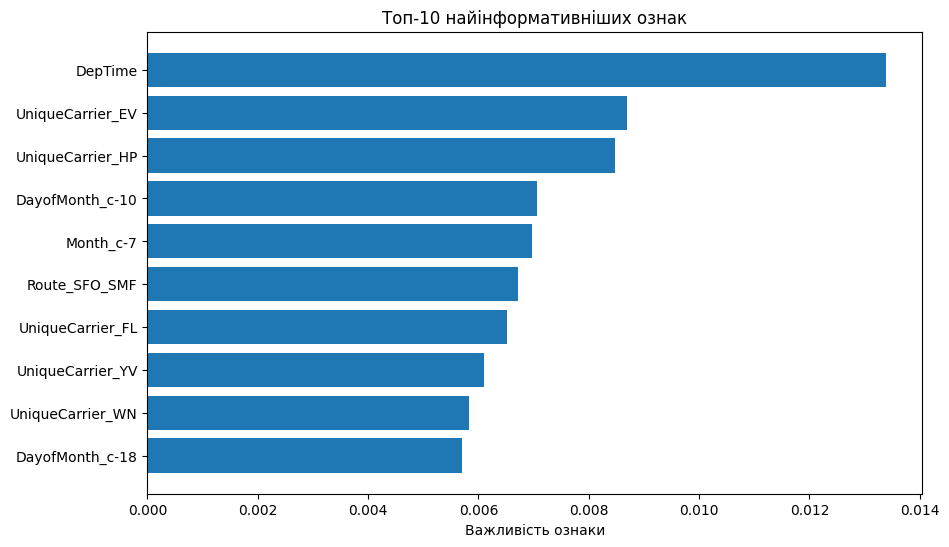

In [17]:
# Оцінка інформативності ознак
import matplotlib.pyplot as plt

# Важливість ознак
feature_importance = model.feature_importances_

# Створення DataFrame для зручного відображення
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

# Виведення топ-10 найінформативніших ознак
print("\nТоп-10 найінформативніших ознак:")
print(importance_df.head(10))

# Побудова графіка важливості ознак
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:10], importance_df['importance'][:10])
plt.gca().invert_yaxis()
plt.xlabel("Важливість ознаки")
plt.title("Топ-10 найінформативніших ознак")
plt.show()


In [19]:
# Масштабування числових ознак у тестових даних
print("\nМасштабування числових ознак у тестових даних...")
test_final[numeric_features] = scaler.transform(test_final[numeric_features])

# Використання найкращої моделі для прогнозування на тестових даних
print("\nПрогнозування на тестових даних за допомогою найкращої моделі...")
best_model = random_search.best_estimator_
test_pred_proba = best_model.predict_proba(test_final)[:, 1]

# Додавання результатів прогнозування до тестових даних
test['Delay_Probability'] = test_pred_proba

# Використання індексу
test_reset = test.reset_index()
test_reset.rename(columns={'index': 'Flight_Index'}, inplace=True)
top_10_delays = test_reset[['Flight_Index', 'Delay_Probability']].sort_values(by='Delay_Probability', ascending=False).head(10)
print("\nТоп-10 рейсів з найвищою ймовірністю затримки:")
print(top_10_delays)


Масштабування числових ознак у тестових даних...

Прогнозування на тестових даних за допомогою найкращої моделі...

Топ-10 рейсів з найвищою ймовірністю затримки:
       Flight_Index  Delay_Probability
3055           3055           0.964953
51532         51532           0.963150
50006         50006           0.963150
14051         14051           0.962566
74838         74838           0.962240
3554           3554           0.958946
13970         13970           0.958163
53719         53719           0.955714
43567         43567           0.955039
40939         40939           0.954921
